# Setup

In [1]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.9 MB/s eta 0:00:00


In [2]:
%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium

# Install xvfb
apt install -y xvfb

# Install Selenium-Profiles
pip uninstall -y selenium_profiles
pip install --no-cache-dir selenium_profiles>=2.2.6

# pip install https://github.com/kaliiiiiiiiii/Selenium-Profiles/archive/refs/heads/dev.zip # dev-branch

# install python packages
pip install google-colab-shell
pip install webdriver-manager
pip install Pyvirtualdisplay

Executing: /tmp/apt-key-gpghome.IFJ8EADA4m/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.A3gleAIlMo/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.8wC5uhud5r/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Hit:2 http://archive.ubuntu.com/ubuntu 

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import pandas as pd

from selenium_profiles.webdriver import Chrome
from selenium_profiles.profiles import profiles
from selenium.webdriver.common.by import By  # locate elements
from selenium_profiles.utils.colab_utils import display, showscreen, show_html # virtual display

from webdriver_manager.chrome import ChromeDriverManager

import re
import datetime
import pytz

pd.set_option("max_colwidth", None)

In [4]:
# geoid setup
# Empty stands for whole United States
# Here I only include part of the geoid, the rest of geoid can be found in the LinkedIn url link mannually
geo = {
    "": "103644278",
    "Alabama": "",
    "Alaska": "",
    "Arizona": "106032500",
    "Arkansas": "102790221",
    "California": "102095887",
    "Colorado": "",
    "Connecticut": "",
    "Delaware": "105375497",
    "Florida": "101318387",
    "Georgia": "106315325",
    "Hawaii": "",
    "Idaho": "102560739",
    "Illinois": "101949407",
    "Indiana": "",
    "Iowa": "",
    "Kansas": "",
    "Kentucky": "",
    "Louisiana": "",
    "Maine": "",
    "Maryland": "100809221",
    "Massachusetts": "101098412",
    "Michigan": "103051080",
    "Minnesota": "103411167",
    "Mississippi": "",
    "Missouri": "",
    "Montana": "",
    "Nebraska": "101197782",
    "Nevada": "101690912",
    "New Hampshire": "103532695",
    "New Jersey": "101651951",
    "New Mexico": "105048220",
    "New York": "105080838",
    "North Carolina": "103255397",
    "North Dakota": "",
    "Ohio": "",
    "Oklahoma": "",
    "Oregon": "101685541",
    "Pennsylvania": "102986501",
    "Rhode Island": "",
    "South Carolina": "",
    "South Dakota": "",
    "Tennessee": "104629187",
    "Texas": "102748797",
    "Utah": "",
    "Vermont": "",
    "Virginia": "101630962",
    "Washington": "103977389",
    "West Virginia": "106420769",
    "Wisconsin": "104454774",
    "Wyoming": "",
}

In [5]:
#Chromedriver setup
chromedriver_path = ChromeDriverManager(version="90.0.4430.24").install()

profile = profiles.Windows() # or .Android
profile["cdp"]["cores"] = None # Chrome 90 doesn't allow emulating cores :(driver = mydriver.start(profile, uc_driver=False, executable_path=chromedriver_path)


from selenium.webdriver.chrome.options import Options

options = Options()

options = webdriver.ChromeOptions()
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
options.add_argument('--headless')

driver = Chrome(profile, executable_path=chromedriver_path, options = options)

display = display()
display.start_display()

[WDM] - Downloading: 100%|██████████| 5.53M/5.53M [00:00<00:00, 7.95MB/s]
/usr/local/lib/python3.10/dist-packages/selenium_profiles/scripts/profiles.py:402: UserWarning: exact duplicate found for --no-sandbox, skipping
  warnings.warn(f"exact duplicate found for {my_option}, skipping")


# Creating function and changing display order

In [6]:
def get_job(job_name_, days_, state_name_, job_max = None, keywords = ['data scientist', 'data analyst', 'machine learning', "data", "scientist", "analyst", "analytics", "intelligence"]):
  job_name = job_name_.replace(' ','%20')
  geoId = geo[state_name_]
  state_name = state_name_.replace(' ','%20')
  day_sec = 86400
  days = str(days_*day_sec)

  url = "https://www.linkedin.com/jobs/search?f_JT=F&f_TPR=r{0}&keywords={1}&location={2}%2C%20United%20States&geoId={3}&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0"
  url = url.format(days, job_name, state_name, geoId)

  driver.get(url)

  #We find how many jobs are offered.
  jobs_num = driver.find_element(By.CSS_SELECTOR,"h1>span").get_attribute("innerText")
  if len(jobs_num.split(',')) > 1:
    jobs_num = int(jobs_num.split(',')[0])*1000
  else:
    jobs_num = int(jobs_num)

  jobs_num   = int(jobs_num)

  #We create a while loop to browse all jobs.
  if job_max == None:
    job_max = int(jobs_num/2)+1

  i = 2
  while i <= job_max:
    #We keep scrollind down to the end of the view.
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    i = i + 1
    print("Current at: ", i, "Percentage at: ", ((i+1)/(int(jobs_num/2)+1))*100, "%",end="\r")
    try:
      #We try to click on the load more results buttons in case it is already displayed.
      # infinite_scroller_button = driver.find_element(By.XPATH, ".//button[@aria-label='Load more results']")
      infinite_scroller_button = driver.find_element(By.XPATH, ".//button[@aria-label='See more jobs']")
      infinite_scroller_button.click()
      time.sleep(0.1)
    except:
      #If there is no button, there will be an error, so we keep scrolling down.
      time.sleep(0.1)
      pass

  #We get a list containing all jobs that we have found.
  job_lists = driver.find_element(By.CLASS_NAME,"jobs-search__results-list")
  jobs = job_lists.find_elements(By.TAG_NAME,"li") # return a list

  #We declare void list to keep track of all obtaind data.
  job_title_list = []
  company_name_list = []
  location_list = []
  date_list = []
  job_link_list = []
  time_since_pub_list = []

  #We loof over every job and obtain all the wanted info.
  for job in jobs:
    #job_title
    job_title = job.find_element(By.CSS_SELECTOR,"h3").get_attribute("innerText")
    job_title_list.append(job_title)

    #company_name
    company_name = job.find_element(By.CSS_SELECTOR,"h4").get_attribute("innerText")
    company_name_list.append(company_name)

    #location
    location = job.find_element(By.CSS_SELECTOR,"div>div>span").get_attribute("innerText")
    location_list.append(location)

    #date
    date = job.find_element(By.CSS_SELECTOR,"div>div>time").get_attribute("datetime")
    date_list.append(date)

    #job_link
    job_link = job.find_element(By.CSS_SELECTOR,"a").get_attribute("href")
    job_link_list.append(job_link)

    #job_post_ago
    time_since_pub = job.find_element(By.CSS_SELECTOR,"div>div>time").text
    time_since_pub_list.append(time_since_pub)



  contents = []            # Create an empty list to store data.
  applicants = []
  for link in job_link_list:
    try:
      driver.get(link)   # Go to the link
      # Find the 'Show more' button and click it
      driver.find_element(By.XPATH,'//*[@id="main-content"]/section[1]/div/div/section[1]/div/div/section/button[1]').click()
      time.sleep(1)      # Let the details load
      try:
        content=driver.find_element(By.CLASS_NAME,'show-more-less-html__markup').text    # Find the details on page
        contents.append(content)       # Append the content into the list
      except:
        contents.append("None")
        ValueError('no content')
      try:
        applicant=driver.find_element(By.CLASS_NAME,'num-applicants__caption').text    # Find the details on page
        applicants.append(applicant)       # Append the content into the list
      except:
        applicants.append("0 applicant")
        ValueError('no applicant')
    except:
      contents.append("None")
      applicants.append("None")
      ValueError('sth is wrong')
      time.sleep(5)

  yoe = [] # year of experience
  noa = [] # number of applicant

  for content in contents:
    match = re.search(r'\b(\d+|\d\+|\d-\d)\s+years?\b', content)
    if match:
      years_of_experience = match.group(0)
      yoe.append(years_of_experience)
    else:
      if content == "None":
        yoe.append("Oops")
      else:
        yoe.append("None")

  for applicant in applicants:
    match = re.search('\d+', applicant)
    if match:
      number_of_applicant = int(match.group())
      noa.append(number_of_applicant)
    else:
      noa.append("Oops")

  tz = pytz.timezone('US/Central')
  now = datetime.datetime.now(tz)

  job_data = pd.DataFrame({
      'Date': date_list,
      "Write time": [now]*len(date_list),
      "Time": time_since_pub_list,
      "Number of applicant": noa,
      'Company': company_name_list,
      'Title': job_title_list,
      'Location': location_list,
      "Year of experience": yoe,
      'Link': job_link_list
  })


  # create a function to mark the rows
  def mark_rows(title):
      if any(keyword in title.lower() for keyword in keywords):
          return 0
      else:
          return 1

  # apply the function to create a new column
  job_data['Mark'] = job_data['Title'].apply(mark_rows)

  job_data = job_data.sort_values(["Mark", "Year of experience", "Number of applicant"])

  file_name = "{0}_at_{1}_within_{2}_days_{3}.csv"
  file_name = file_name.format(job_name_, state_name_, days_, now)

  job_data.to_csv(file_name, index = False)

  return job_data



In [7]:
# Job name for LinkedIn to search
job_name = "Data Scientist"

# Jobs posted within ? days
# Can set it as 0.5
days = 1

# Empty for the whole United States
# The first letter should be capitalized
state_name = "California"

# The maximum number of job post, if not specified will obtain all the jobs loaded
# But I don't suggest to use the default, as LinkedIn will display thousands or tens of thousands, but the ones towards the end are all random
# There should be around dozens or hundreds, if it's within one day, which is based on my observation of current market
job_max = 60

# List of job titles to be marked as 0, therefore being displayed in a higher rank
# All lowercase
# default keywords = ['data scientist', 'data analyst', 'machine learning', "data", "scientist", "analyst", "analytics", "intelligence"]
keywords = ['data scientist', 'data analyst', 'machine learning', "data", "scientist", "analyst", "analytics", "intelligence"]

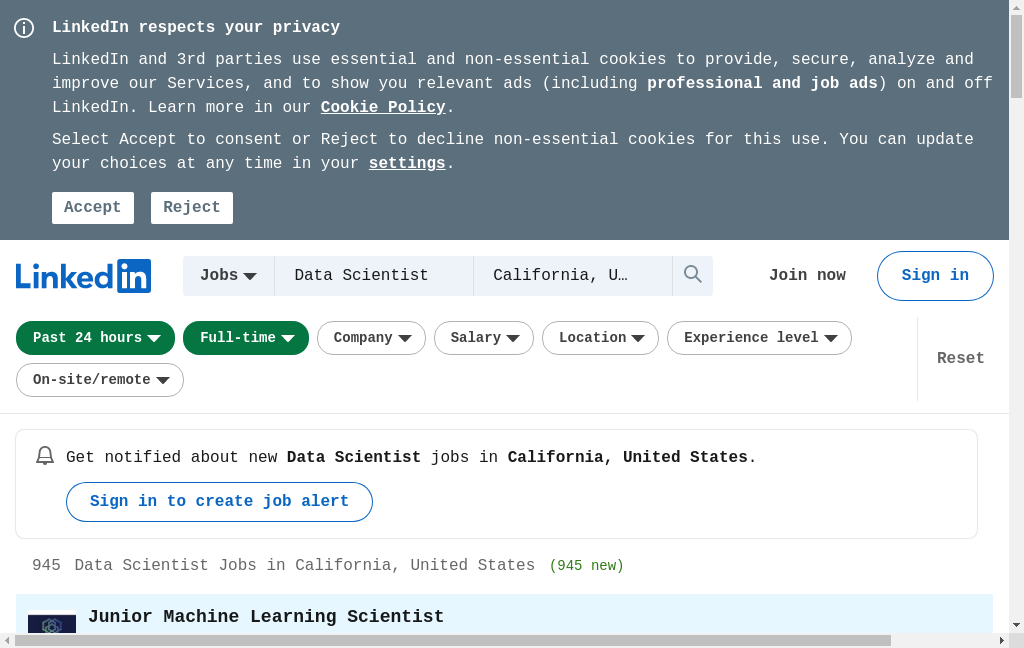

In [8]:
# Double-check if the URL is correct
def get_url(job_name_, days_, state_name_):
  job_name = job_name_.replace(' ','%20')
  geoId = geo[state_name_]
  state_name = state_name_.replace(' ','%20')
  day_sec = 86400
  days = str(days_*day_sec)

  url = "https://www.linkedin.com/jobs/search?f_JT=F&f_TPR=r{0}&keywords={1}&location={2}%2C%20United%20States&geoId={3}&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0"
  url = url.format(days, job_name, state_name, geoId)

  return url

url = get_url(job_name, days, state_name)
driver.get(url)
showscreen(driver)

In [9]:
get_job(job_name, days, state_name, job_max, keywords)

,Date,Write time,Time,Number of applicant,Company,Title,Location,Year of experience,Link,Mark
0,2023-07-19,2023-07-19 19:54:15.234588-05:00,10 hours ago,25,Patterned Learning AI,Junior Machine Learning Scientist,"San Francisco, CA",1 year,https://www.linkedin.com/jobs/view/junior-machine-learning-scientist-at-patterned-learning-ai-3668255833?refId=rU7o8tSh1kzOn%2FJGkBIKpA%3D%3D&trackingId=VJcf%2BmVsAHo%2BKbhi3ssL9w%3D%3D&position=1&pageNum=0&trk=public_jobs_jserp-result_search-card,0
150,2023-07-19,2023-07-19 19:54:15.234588-05:00,7 hours ago,25,ecocareers,Staff Geospatial Scientist,"Pasadena, CA",1 year,https://www.linkedin.com/jobs/view/staff-geospatial-scientist-at-ecocareers-3668478925?refId=3ZZcpvPgEcPsrzuD59s3wQ%3D%3D&trackingId=a%2FWEnyE4rFfMdyAL5IGDPw%3D%3D&position=1&pageNum=6&trk=public_jobs_jserp-result_search-card,0
36,2023-07-19,2023-07-19 19:54:15.234588-05:00,7 hours ago,25,Braintrust,Software Engineer (Machine Learning) IC3 - Freelance [Remote],"Los Angeles, CA",1+ years,https://www.linkedin.com/jobs/view/software-engineer-machine-learning-ic3-freelance-remote-at-braintrust-3668496392?refId=%2FpfS%2Fbe%2BB4bsf75IUZy3%2Fw%3D%3D&trackingId=pcpcc3rM7aJFGfmTm%2BgrZA%3D%3D&position=12&pageNum=1&trk=public_jobs_jserp-result_search-card,0
14,2023-07-19,2023-07-19 19:54:15.234588-05:00,8 hours ago,53,Meta,"Software Engineer, Machine Learning","Menlo Park, CA",2+ years,https://www.linkedin.com/jobs/view/software-engineer-machine-learning-at-meta-3668458437?refId=rU7o8tSh1kzOn%2FJGkBIKpA%3D%3D&trackingId=xOf%2Bhe%2BZ%2F%2FNRTBJDVbQLAQ%3D%3D&position=15&pageNum=0&trk=public_jobs_jserp-result_search-card,0
37,2023-07-19,2023-07-19 19:54:15.234588-05:00,8 hours ago,25,BioSpace,"Scientist II, Human Genetics Data Scientist","San Diego, CA",3+ years,https://www.linkedin.com/jobs/view/scientist-ii-human-genetics-data-scientist-at-biospace-3668433158?refId=%2FpfS%2Fbe%2BB4bsf75IUZy3%2Fw%3D%3D&trackingId=Tv2S1QsSgf2TPfHQis2sgQ%3D%3D&position=13&pageNum=1&trk=public_jobs_jserp-result_search-card,0
...,...,...,...,...,...,...,...,...,...,...
190,2023-07-19,2023-07-19 19:54:15.234588-05:00,1 day ago,Oops,NVIDIA,"Senior Software Architect, AI and HPC","Santa Clara, CA",Oops,https://www.linkedin.com/jobs/view/senior-software-architect-ai-and-hpc-at-nvidia-3669679284?refId=aqPvkB5EtN9XLg2oqTeG4g%3D%3D&trackingId=XEQIngzED6fPU7Ba15qw4Q%3D%3D&position=16&pageNum=7&trk=public_jobs_jserp-result_search-card,1
192,2023-07-19,2023-07-19 19:54:15.234588-05:00,22 hours ago,Oops,Braintrust,Full-stack web developer (backend focused) - Freelance [Remote],"Los Angeles, CA",Oops,https://www.linkedin.com/jobs/view/full-stack-web-developer-backend-focused-freelance-remote-at-braintrust-3669692568?refId=aqPvkB5EtN9XLg2oqTeG4g%3D%3D&trackingId=imReHn4mAcN15Xnbm0AZnA%3D%3D&position=18&pageNum=7&trk=public_jobs_jserp-result_search-card,1
194,2023-07-19,2023-07-19 19:54:15.234588-05:00,7 hours ago,Oops,Apple,iOS Home Application Engineer,"Cupertino, CA",Oops,https://www.linkedin.com/jobs/view/ios-home-application-engineer-at-apple-3666467999?refId=aqPvkB5EtN9XLg2oqTeG4g%3D%3D&trackingId=0oqK2WtU1S%2FQrpooSHO95w%3D%3D&position=20&pageNum=7&trk=public_jobs_jserp-result_search-card,1
198,2023-07-19,2023-07-19 19:54:15.234588-05:00,13 hours ago,Oops,CyberCoders,Software Controls Engineer,"Sunnyvale, CA",Oops,https://www.linkedin.com/jobs/view/software-controls-engineer-at-cybercoders-3646353820?refId=aqPvkB5EtN9XLg2oqTeG4g%3D%3D&trackingId=IboBr%2B%2BkTOQPf02QTtMRpQ%3D%3D&position=24&pageNum=7&trk=public_jobs_jserp-result_search-card,1
